# Deep Learning

## Tensorflow

Google's libraries for optimizing data flows through graphs and it has been mainly used for Deep Learning tasks. Part of its advantages is that is designed to work with multiple CPUs and GPUs.

For TensorFlow, the data been transfer between nodes in the graphs are **tensors** (multi-dimensional data arrays).

### Basic calculations

**Constants and variables**

In [1]:
import tensorflow as tf

const = tf.constant(2.0, name="const")

b = tf.Variable(2.0, name='b')
c = tf.Variable(1.0, name='c')

**Operations**

In [2]:
d = tf.add(b, c, name='d')
e = tf.add(c, const, name='e')
a = tf.multiply(d, e, name='a')

### Initializing

In TensorFlow you need initialize the declared variables, constants and operationon a session to use them.

In [3]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    res = sess.run(a)
    print(res)

9.0


**Placeholders**

Sometimes you know that you will need a variable but you don't know his initialization value, in this cases you can setup a placeholder.

In [5]:
const = tf.constant(2.0, name="const")

b = tf.placeholder(tf.float32, [None,1], name='b')
c = tf.Variable(1.0, name='c')
d = tf.add(b, c, name='d')
e = tf.add(c, const, name='e')
a = tf.multiply(d, e, name='a')

We need to define the type and the dimensions like second argument, (None, 1) means that we can accept any variable size of 1 dimension. Now in order to add it to TensorFlow scope we need to pass to the session run line a dictionary with the placeholder definition.

In [7]:
import numpy as np

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    res = sess.run(a, feed_dict={b: np.arange(0, 10)[:, np.newaxis]})
    print(res)


[[ 3.]
 [ 6.]
 [ 9.]
 [12.]
 [15.]
 [18.]
 [21.]
 [24.]
 [27.]
 [30.]]


### Neural Network

Now let's try to re-build the MNIST excersice with TensorFlow.

**Data**

First let's load the data.

In [8]:
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def vectorizer(y):
    yVector = np.zeros((len(y), 10))
    for i in range(len(y)):
        yVector[i, y[i]] = 1
    return yVector

In [9]:
digits = load_digits()

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x = scaler.fit_transform(digits.data)
y = digits.target
categories = list(set(y))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.4)
yVecTrain = vectorizer(yTrain)
yVecTest = vectorizer(yTest)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

**Network**

In [8]:
lr = 0.5
epochs = 10
batchSize = 1

x = tf.placeholder(tf.float32, [None, 64])
y = tf.placeholder(tf.float32, [None, 10])

W1 = tf.Variable(tf.random_normal([64, 32], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([32]), name='b1')
z1 = tf.add(tf.matmul(x, W1), b1)
h1 = tf.nn.sigmoid(z1)

W2 = tf.Variable(tf.random_normal([32, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')
yPred = tf.nn.softmax(tf.add(tf.matmul(h1, W2), b2))

error = tf.nn.l2_loss(yPred - y)
optimiser = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(error)

init = tf.global_variables_initializer()
evaluation = tf.equal(tf.argmax(y, 1), tf.argmax(yPred, 1))
accuracy = tf.reduce_mean(tf.cast(evaluation, tf.float32))
prediction = tf.argmax(yPred, 1)

**Training & metrics**

Code modified from: https://adventuresinmachinelearning.com/python-tensorflow-tutorial/

In [9]:
with tf.Session() as sess:
    sess.run(init)
    totalBatch = int(len(yTrain) / batchSize)
    for epoch in range(epochs):
        avgCost = 0
        for i in range(totalBatch):
            batchX, batchY = xTrain[i:i+batchSize], yVecTrain[i:i+batchSize]
            _, c = sess.run([optimiser, error], feed_dict={x: batchX, y: batchY})
            avgCost += c / totalBatch
        print("Epoch:", (epoch + 1), "cost =", "{:.6f}".format(avgCost))
    print(sess.run(accuracy, feed_dict={x: xTest, y: yVecTest})*100)
    
    pred = sess.run(prediction, feed_dict={x: xTest, y: yVecTest})
    print(classification_report(y_pred=pred, y_true=yTest, labels=categories))

Epoch: 1 cost = 0.448281
Epoch: 2 cost = 0.269822
Epoch: 3 cost = 0.099279
Epoch: 4 cost = 0.054049
Epoch: 5 cost = 0.039309
Epoch: 6 cost = 0.033154
Epoch: 7 cost = 0.024540
Epoch: 8 cost = 0.020702
Epoch: 9 cost = 0.017692
Epoch: 10 cost = 0.015219
94.85396146774292
             precision    recall  f1-score   support

          0       0.98      0.97      0.97        87
          1       0.96      0.94      0.95        82
          2       0.94      1.00      0.97        72
          3       1.00      0.81      0.89        72
          4       0.95      0.95      0.95        74
          5       0.94      0.94      0.94        70
          6       0.96      1.00      0.98        66
          7       0.96      0.99      0.97        72
          8       0.92      0.92      0.92        65
          9       0.88      0.98      0.93        59

avg / total       0.95      0.95      0.95       719



### Confusion matrix

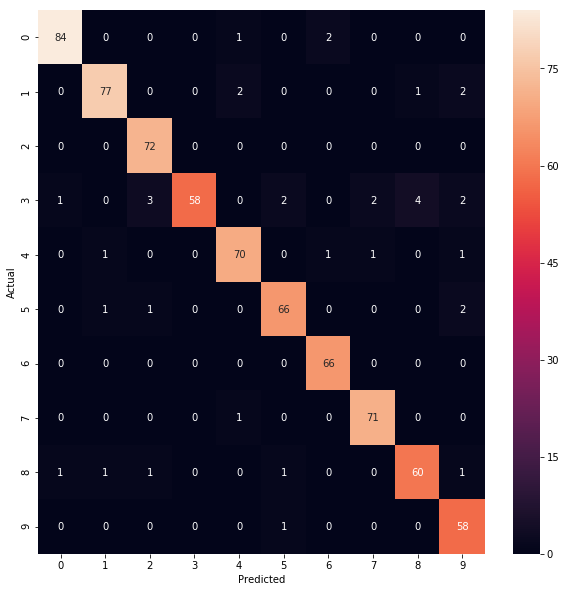

In [10]:
cm = confusion_matrix(yTest, pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()